In [1]:
%run EUVIP_1_defaults.ipynb

Range of spatial frequencies:  [ 0.618   0.382   0.2361  0.1459  0.0902  0.0557  0.0344  0.0213]
Range of angles (in degrees):  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]
Final sparseness in the representation = 0.0026041666666666665
Final sparseness in the pyramid = 0.375


In [2]:
%cd -q ../test/

# objective :  fitting the pdf of sparse coefficients

It seems that sparse coefficients decrease in a sterotyped fashion - understanding how may be important to apply that knowledge to image compression but also to understand generative models for images.


Here, we are trying different parameterizations of the PDF, first a log-normal or a gamma function, then a power law.

In [3]:
!pip3 install -U lmfit

Requirement already up-to-date: lmfit in /usr/local/lib/python3.6/site-packages
Requirement already up-to-date: scipy in /usr/local/lib/python3.6/site-packages (from lmfit)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/site-packages (from lmfit)


##  fitting a parameterized PDF on synthetic data

Let's first try to fit a log-Normal distribution:

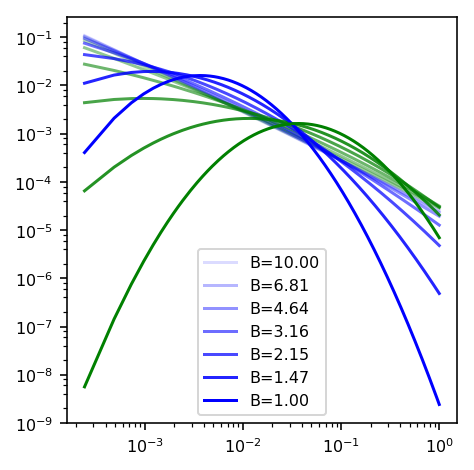

In [4]:
x = np.linspace(1, 0, N, endpoint=False)[::-1]
    
def model(x, x_0, B):
    f =  1/x * np.exp( -.5 * np.log(x/x_0)**2 / B**2 )
    f /= f.sum()
    return f

ratio = 1
fig, ax = plt.subplots(1, 1, figsize=(fig_width/ratio, fig_width/ratio))
ax.axis(c='b', lw=2, axisbg='w')
ax.set_axis_bgcolor('w')
    
im_contrasts = 1. * np.logspace(-1, 0, 7)
for i_contrast, im_contrast in enumerate(im_contrasts):
    
    ax.loglog(x, model(x, x_0=.01, B=1./im_contrast), c='b', alpha=(i_contrast+1)/len(im_contrasts), label='B=%.2f' % (1./im_contrast))
    ax.loglog(x, model(x, x_0=.1, B=1./im_contrast), c='g', alpha=(i_contrast+1)/len(im_contrasts))

ax.legend(loc='best')
fig.tight_layout()

### Fitting

We use a Levenberg-Marcquardt method to fir the data with this distribution, as is easily implemented in the [lmfit](http://lmfit.github.io/lmfit-py/) package:

[[Variables]]
    x_0:   0.01000024 (init= 0.05)
    B:     1.00003388 (init= 0.15)
[[Correlations]] (unreported correlations are <  0.100)


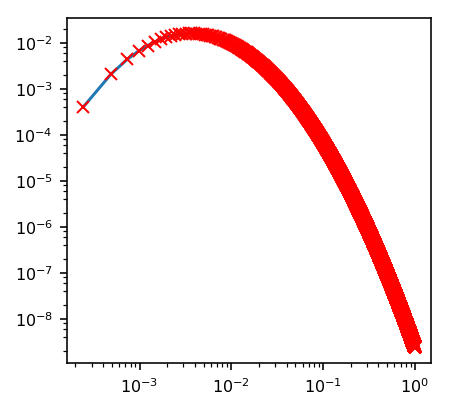

In [5]:
import lmfit
from lmfit import Model
logN_mod = Model(model)
logN_mod.set_param_hint('x_0', value=0.05, min=0.)
logN_mod.set_param_hint('B', value=.15, min=0.)

proba = model(x, x_0=0.01, B=1.)
mi = logN_mod.fit(proba, x=x, method='Nelder')
#mi = lmfit.minimize(residual, p, args=(x, proba,), method='Nelder')
lmfit.printfuncs.report_fit(mi.params)#, min_correl=0.5)

fig, ax = plt.subplots(1, 1, figsize=(fig_width/ratio, fig_width/ratio))
ax.loglog(x, mi.best_fit)
ax.loglog(x, proba, 'rx')

## Power-law : Random sample generation
Random samples can be generated using inverse transform sampling. Given a random variate $U$ drawn from the uniform distribution on the unit interval $(0 1]$, the variate $T$ given by

$$
T=\frac{x_\mathrm{m}}{U^{\frac{1}{\alpha}}}
$$

is Pareto-distributed

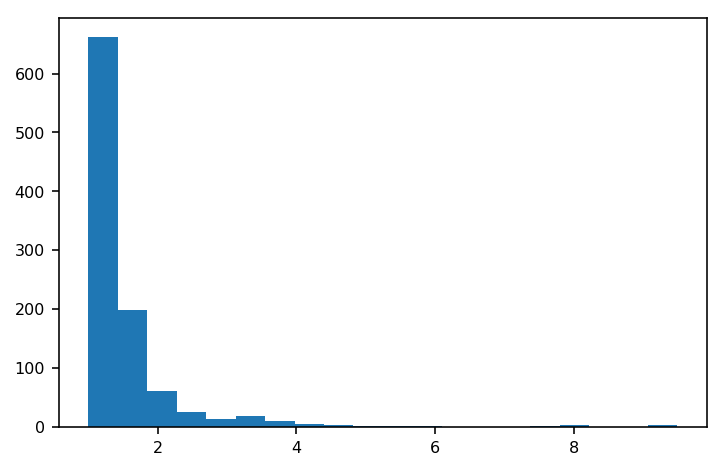

In [6]:
#from scipy.stats import powerlaw
#r = 1. / powerlaw.rvs(a = 10, size = 1000)
a, m = 3., 1.  # shape and mode
r = (np.random.pareto(a, 1000) + 1) * m
_= plt.hist(r, bins=20)

0.147871978011
0.621495025994
0.763989734326
0.83160869497
0.870704477349
0.895524405585


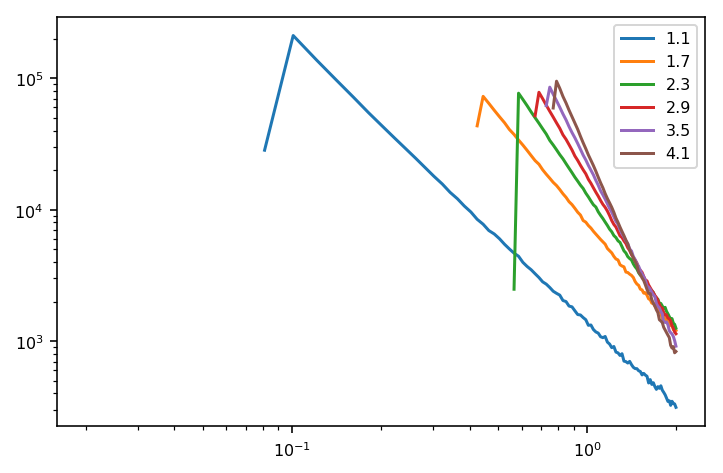

In [7]:
N_sparse = 6
sparseness =  np.linspace(1.1, 4.1, N_sparse, endpoint=True)
N_edge = 1.e6

fig , ax = plt.subplots()
bins = np.linspace(1, 10, 100)
bins = np.linspace(0, 2, 100)
for a in sparseness:
    s =  (np.random.pareto(a=a, size=int(N_edge)) + 1) * m
    #s = 1/powerlaw.rvs(a=a, size = N_edge)
    s /= s.mean()
    hist, bins_ = np.histogram(s, bins=bins)
    ax.loglog(bins[1:], hist, label=a)
    print(np.median(s))
ax.legend()
    

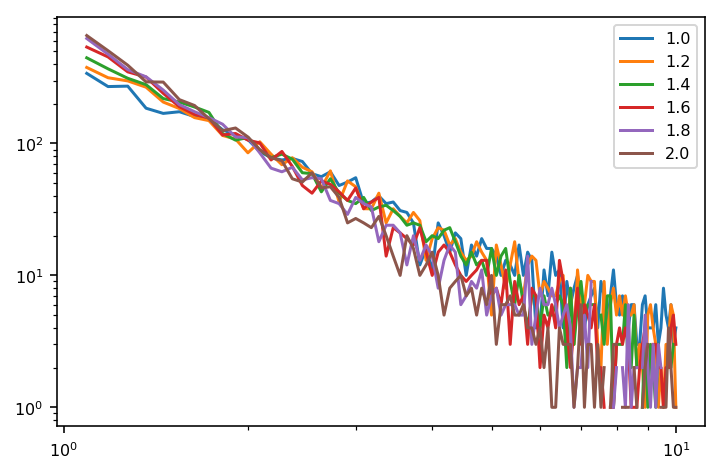

In [8]:
from scipy.stats import powerlaw
N_sparse = 6
sparseness =  np.linspace(1., 2, N_sparse, endpoint=True)
N_edge = N

fig , ax = plt.subplots()
bins= np.linspace(1, 10, 100)
for a in sparseness:
    #s =  np.random.power(a=a, size=N_edge) 
    s = np.random.pareto(a=a, size=(N_edge)) + 1
    #s = 1/powerlaw.rvs(a=a, size = N_edge)
    hist, bins_ = np.histogram(s, bins=bins)
    ax.loglog(bins[1:], hist, label=a)
ax.legend()
    

Now, we may also create new models by introducing a transition  from the power-law to a Gaussian:

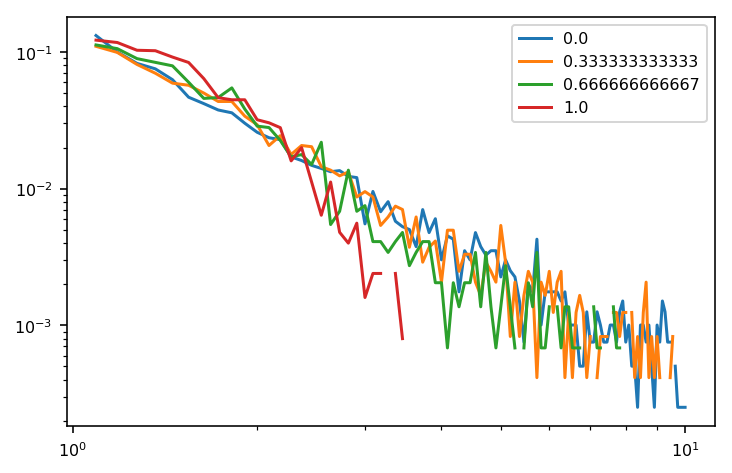

In [9]:
N_noise = 4
a = 1.5
noises =  np.linspace(0., 1., N_noise, endpoint=True)

fig , ax = plt.subplots()
bins = np.linspace(1, 10, 100)
for noise in noises:
    s = (1-noise)*(np.random.pareto(a=a, size=(N_edge)) + 1)
    n = noise*np.random.randn(N_edge)
    hist, bins_ = np.histogram(np.abs(n+s), bins=bins, density=True)
    hist /= hist.sum()
    ax.loglog(bins[1:], hist, label=noise)
ax.legend()
    

## doing the fits on the *real* activation data

In [10]:
imagelist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
value = edgeslist[4, ...].T
value /= RMSE[:, 0][:, np.newaxis]
RMSE /= RMSE[:, 0][:, np.newaxis]
RMSE = RMSE**2
N_image, N = RMSE.shape #number of images and edges
print(N_image, N )

100 4096


In [11]:
a_min = value.min()
a_max = value.max()

#a_min = 10**-1.5
print('Min=', a_min, 'Max=', a_max, 'shape=', value.shape, 'Max=', value.max(axis=1))

Min= 3.3227408588e-05 Max= 0.0187982302149 shape= (100, 4096) Max= [ 0.0012  0.0023  0.0032  0.0025  0.0018  0.0081  0.009   0.0033  0.0026
  0.0039  0.0038  0.0026  0.0018  0.0024  0.0109  0.0188  0.0109  0.0077
  0.0036  0.0023  0.0031  0.0027  0.0034  0.0048  0.0031  0.0032  0.0029
  0.0025  0.0037  0.0062  0.0033  0.0027  0.0026  0.0032  0.0056  0.0061
  0.002   0.0081  0.0013  0.0025  0.0103  0.0036  0.0034  0.0049  0.005
  0.004   0.0034  0.003   0.0027  0.0017  0.0019  0.0028  0.0011  0.0026
  0.0026  0.0049  0.0041  0.0013  0.0021  0.0019  0.0018  0.0016  0.0033
  0.0026  0.0023  0.0031  0.0031  0.0034  0.0015  0.0029  0.0058  0.0049
  0.0012  0.0155  0.0023  0.0036  0.0067  0.0022  0.0039  0.0011  0.0105
  0.0017  0.0035  0.0034  0.0045  0.0035  0.0032  0.0033  0.0051  0.006
  0.0033  0.0013  0.0103  0.0033  0.006   0.0114  0.0073  0.004   0.0096
  0.0015]


In [12]:
v_hist = np.zeros((N_image, N_bins))
bins = np.linspace(0, a_max, N_bins+1, endpoint=True)
bins = a_max*np.logspace(np.log10(a_min/a_max), 0, N_bins+1, endpoint=True, base=10)
print('bins used = ', bins, bins.shape)
for i_image in range(N_image):
    v_hist[i_image, : ], v_bins = np.histogram(value[i_image, :], bins=bins, density=True) 
    #v_hist[i_image, : ], v_bins = np.histogram(value[i_image, :], bins=N_bins) 
    v_hist[i_image, : ] /= v_hist[i_image, : ].sum()
v_middle = .5*(v_bins[1:]+v_bins[:-1])

NameError: name 'N_bins' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})

for i_image in range(N_image):
    valid = (v_hist[i_image, :] > 0.)
    ax.plot(v_middle[valid], v_hist[i_image, valid], '.', alpha=.2)
    #ax.plot(v_middle, v_hist[i_image, :], alpha=.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(a_min, a_max)
    #ax.set_ylim(.0009, .05)
    ax.set_ylabel('(log) Probability density')
    ax.set_xlabel('(log) coefficient')            

mp.savefig(fig, experiment + '_proba')

MLE estimate of rho:
https://en.wikipedia.org/wiki/Power_law#Maximum_likelihood


In [ ]:

amplitude, rho = np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    start = np.argmax(v_hist[i_image, :] > 0.) + 1
    stop = (v_hist[i_image, :] == 0.)
    #v_hist[i_image, :], start,  stop#, v_hist[i_image, start:stop]

    rho[i_image] =  1 +  (stop-start) / np.sum(np.log(value[i_image, start:stop]))
    amplitude[i_image] = rho[i_image] - 1
print('MLE estimate' , rho)



In [ ]:
from lmfit.models import ExpressionModel
mod = ExpressionModel('amplitude * x**-rho ')
def_vals = {'amplitude':1.e-6, 'rho':a}
weights = np.linspace(0, 1, N_bins)
weights = np.ones(N_bins)
weights = np.linspace(1, 0, N_bins)


#mod = ExpressionModel('amplitude * exp( - log(x)**2/rho**2 ) ')
#mod = ExpressionModel('amplitude * exp( - x/rho ) ')
verbose = False
amplitude, rho = np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    mod.def_vals = def_vals
    valid = (v_hist[i_image, :] > 0.)
    #print(start, end)
    out  = mod.fit(v_hist[i_image, valid], x=v_middle[valid], verbose=verbose, weights=weights[valid])
    #print(out.fit_report())
    amplitude[i_image] = out.params.get('amplitude').value
    rho[i_image] =  out.params.get('rho').value
print ('amplitude=', amplitude.mean(), ', +/- ', amplitude.std())    
print ('rho=', rho.mean(), ', +/- ', rho.std())    


In [ ]:
start = 10
#fig, ax = plt.subplots(1, 1, figsize=(fig_width/2, fig_width/2), subplot_kw={'axisbg':'w'})
fig = plt.figure(figsize=(fig_width, fig_width/1.618))

ax = fig.add_axes([0.2, 0.2, .78, .78], axisbg='w')
for i_image in range(N_image):
    #ax.plot(v_middle[start:], v_hist[i_image, start:], '-', alpha=.1, lw=.5)
    params = mod.make_params(amplitude=amplitude[i_image], rho=rho[i_image])
    valid = (v_hist[i_image, :] > 0.)
    ax.plot(v_middle[valid], v_hist[i_image, valid], '-', alpha=.2, lw=.5)
    ax.plot(v_middle[valid], mod.eval(params, x=v_middle[valid]), 'r', alpha=.2, lw=.5)
    ax.set_yscale('log')
    ax.set_xscale('log')
    #ax.set_xticks([])            
    #ax.set_yticks([])            
    ax.axis('tight')
    ax.set_xlim(a_min*1.5, a_max)
    ax.set_ylim(.00015, .25)
    ax.set_ylabel('(log) Probability density')
    ax.set_xlabel('(log) coefficient')            


inset = fig.add_axes([0.57, 0.72, .4, .25], axisbg='w')
inset.hist(np.abs(rho), bins=np.linspace(1.2, 2.2, 10))
inset.axis('tight')
_ = inset.set_ylabel('')            
_ = inset.set_yticks([])            
_ = inset.set_xticks([1.4, 1.7, 2.0])            
inset.set_ylabel('#')# occurences')            
inset.set_xlabel(r'$\rho$');


### Pareto

As such, we model now the PDF as a [Pareto pdf](https://en.wikipedia.org/wiki/Pareto_distribution)  given by the cumulative:

$$
P(X>x) = \begin{cases}
1 - \left(\frac{x_\mathrm{m}}{x}\right)^\alpha & x\ge x_\mathrm{m}, \\
1 & x < x_\mathrm{m}.
\end{cases}
$$


That is, by the probability density function

$$
f_X(x)= \begin{cases} \frac{\alpha x_\mathrm{m}^\alpha}{x^{\alpha+1}} & x \ge x_\mathrm{m}, \\ 0 & x < x_\mathrm{m}. \end{cases} 
$$


where xm is the (necessarily positive) minimum possible value of X, and α is a positive parameter. 

#### computing histograms

In [ ]:
imagelist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
value = edgeslist[4, ...].T

In [ ]:
#value /= value[:, 0][:, np.newaxis]
#value /= value.max(axis=1)[:, np.newaxis]
value /= value.min(axis=1)[:, np.newaxis]
#value /= value.mean(axis=1)[:, np.newaxis]

N_image, N = value.shape #number of images x edges

N_bins = 128
a_min = value.min()
a_max = value.max()

#a_min = 10**-1.5
print(a_min, a_max, value.shape, value.max(axis=1))

In [ ]:
v_hist = np.zeros((N_image, N_bins))
bins = np.linspace(0, a_max, N_bins+1, endpoint=True)#[:-1]
bins = a_max*np.logspace(np.log10(a_min/a_max), 0, N_bins+1, endpoint=True)#[:-1]
#print(bins.shape)
for i_image in range(N_image):
    v_hist[i_image, : ], v_bins = np.histogram(value[i_image, :], bins=bins, density=True) 
    #v_hist[i_image, : ], v_bins = np.histogram(value[i_image, :], bins=N_bins) 
    v_hist[i_image, : ] /= v_hist[i_image, : ].sum()
v_middle = .5*(v_bins[1:]+v_bins[:-1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})

for i_image in range(N_image):
    ax.plot(v_middle, v_hist[i_image, :], alpha=.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(a_min, a_max)
    #ax.set_ylim(.0009, .05)
    ax.set_ylabel('(log) Probability density')
    ax.set_xlabel('(log) coefficient')            

mp.savefig(fig, experiment + '_proba')

#### log-normal

In [ ]:
import lmfit
from lmfit import Model

def model(x, A, x_0, B):
    f =  A / x * np.exp( -.5 * np.log(x/x_0)**2 / B**2 )
    #f /= f.sum()
    return f

weights = np.linspace(0, 1, N_bins)
weights = np.linspace(1, 0, N_bins)
weights = np.ones(N_bins)
verbose = False

A, x_0, B = np.zeros(N_image), np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    mod = Model(model)
    mod.set_param_hint('A', value=.05, min=0.)
    #mod.set_param_hint('x_0', value=.45, min=0.45, max=0.46)
    mod.set_param_hint('x_0', value=.5, min=0.)
    mod.set_param_hint('B', value=1.9, min=0.)

    valid = (v_hist[i_image, :] > 0.)
    out  = mod.fit(v_hist[i_image, valid], x=v_middle[valid], 
                   verbose=verbose, weights=weights[valid], method='leastsq', maxfev=1e6)
    if verbose: print(out.fit_report())
    A[i_image] = out.params.get('A').value
    x_0[i_image] =  out.params.get('x_0').value
    B[i_image] =  out.params.get('B').value
print ('A=', A.mean(), ', +/- ', A.std())    
print ('x_0=', x_0.mean(), ', +/- ', x_0.std())    
print ('B=', B.mean(), ', +/- ', B.std())    

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})
for i_image in range(N_image):
    ax.plot(v_middle[valid], v_hist[i_image, valid], '.', alpha=.2)
    valid = (v_hist[i_image, :] > 0.)
    #params = mod.make_params(A=A[i_image], x_0=x_0[i_image], B=B[i_image])
    #ax.plot(v_middle[valid], mod.eval(params, x=v_middle[valid]), 'r', alpha=.2)
    ax.plot(v_middle[valid], model(v_middle[valid], A=A[i_image], x_0=x_0[i_image], B=B[i_image]), 'r', alpha=.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axis('tight')
    #ax.set_xlim(a_min, a_max)
    #ax.set_ylim(.0003, .1)
    ax.set_ylabel('(log) Probability density')
    ax.set_xlabel('(log) coefficient')            

mp.savefig(fig, experiment + '_proba')

#### gamma

https://en.wikipedia.org/wiki/Gamma_distribution

In [ ]:
import lmfit
from lmfit import Model

def model(x, A, k, x_0):
    f =  A * x **(k-1) * np.exp( - x/x_0)
    #f /= f.sum()
    return f

weights = np.linspace(0, 1, N_bins)
weights = np.linspace(1, 0, N_bins)
weights = np.ones(N_bins)
verbose = False

A, x_0, k = np.zeros(N_image), np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    mod = Model(model)
    mod.set_param_hint('A', value=.05, min=0.)
    #mod.set_param_hint('x_0', value=.45, min=0.45, max=0.46)
    mod.set_param_hint('x_0', value=5.5, min=0.)
    mod.set_param_hint('k', value=.9, min=0.)

    valid = (v_hist[i_image, :] > 0.)
    out  = mod.fit(v_hist[i_image, valid], x=v_middle[valid], 
                   verbose=verbose, weights=weights[valid], method='leastsq', maxfev=1e6)
    if verbose: print(out.fit_report())
    A[i_image] = out.params.get('A').value
    x_0[i_image] =  out.params.get('x_0').value
    k[i_image] =  out.params.get('k').value
print ('A=', A.mean(), ', +/- ', A.std())    
print ('x_0=', x_0.mean(), ', +/- ', x_0.std())    
print ('k=', k.mean(), ', +/- ', k.std())    

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})
for i_image in range(N_image):
    ax.plot(v_middle[valid], v_hist[i_image, valid], '.', alpha=.2)
    valid = (v_hist[i_image, :] > 0.)
    #params = mod.make_params(A=A[i_image], x_0=x_0[i_image], B=B[i_image])
    #ax.plot(v_middle[valid], mod.eval(params, x=v_middle[valid]), 'r', alpha=.2)
    ax.plot(v_middle[valid], model(v_middle[valid], A=A[i_image], x_0=x_0[i_image], k=k[i_image]), 'r', alpha=.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axis('tight')
    #ax.set_xlim(a_min, a_max)
    ax.set_ylim(.0003, .1)
    ax.set_ylabel('(log) Probability density')
    ax.set_xlabel('(log) coefficient')            

mp.savefig(fig, experiment + '_proba')

In [ ]:
import lmfit
from lmfit import Model

def model(x, A, x_0, B):
    f =  A / x * np.exp( -.5 * np.log(1+x/x_0)**2 / B**2 )
    #f /= f.sum()
    return f

In [ ]:
weights = np.linspace(0, 1, N_bins)
weights = np.linspace(1, 0, N_bins)
weights = np.ones(N_bins)
verbose = False

A, x_0, B = np.zeros(N_image), np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    mod = Model(model)
    mod.set_param_hint('A', value=.05, min=0.)
    #mod.set_param_hint('x_0', value=.45, min=0.45, max=0.46)
    mod.set_param_hint('x_0', value=.5, min=0.)
    mod.set_param_hint('B', value=1.7, min=0.)

    valid = (v_hist[i_image, :] > 0.)
    out  = mod.fit(v_hist[i_image, valid], x=v_middle[valid], 
                   verbose=verbose, weights=weights[valid], method='leastsq', maxfev=1e6)
    if verbose: print(out.fit_report())
    A[i_image] = out.params.get('A').value
    x_0[i_image] =  out.params.get('x_0').value
    B[i_image] =  out.params.get('B').value
print ('A=', A.mean(), ', +/- ', A.std())    
print ('x_0=', x_0.mean(), ', +/- ', x_0.std())    
print ('B=', B.mean(), ', +/- ', B.std())    

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})
for i_image in range(N_image):
    ax.plot(v_middle[valid], v_hist[i_image, valid], '.', alpha=.2)
    valid = (v_hist[i_image, :] > 0.)
    #params = mod.make_params(A=A[i_image], x_0=x_0[i_image], B=B[i_image])
    #ax.plot(v_middle[valid], mod.eval(params, x=v_middle[valid]), 'r', alpha=.2)
    ax.plot(v_middle[valid], model(v_middle[valid], A=A[i_image], x_0=x_0[i_image], B=B[i_image]), 'r', alpha=.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axis('tight')
    #ax.set_xlim(a_min, a_max)
    #ax.set_ylim(.0003, .1)
    ax.set_ylabel('(log) Probability density')
    ax.set_xlabel('(log) coefficient')            

#mp.savefig(fig, experiment + '_proba')

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})

axs.hist(B, bins=np.linspace(.7, 4., 15))
axs.axis('tight')
_ = axs.set_ylabel('')            
_ = axs.set_yticks([])            
axs.set_ylabel('probability density')            
axs.set_xlabel(r'$B$')
fig.tight_layout()
#mp.savefig(fig, experiment + '_fit_hist')

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(fig_width, fig_width), subplot_kw={'axisbg':'w'})

axs.scatter(x_0, B)
axs.axis('tight')
axs.set_xlabel(r'$x_0$')
axs.set_ylabel(r'$B$')
fig.tight_layout()


In [ ]:
start = 10
#fig, ax = plt.subplots(1, 1, figsize=(fig_width/2, fig_width/2), subplot_kw={'axisbg':'w'})
#fig = plt.figure(figsize=(fig_width, fig_width/1.618))
fig = plt.figure(figsize=(fig_width, fig_width/1.5))


ax = fig.add_axes([0.2, 0.2, .78, .78], axisbg='w')
for i_image in range(N_image):
    ax.plot(v_middle, v_hist[i_image, :], '-', alpha=.1, lw=.5)
    ax.plot(v_middle[valid], model(v_middle[valid], A=A[i_image], x_0=x_0[i_image], B=B[i_image]), 
            'r', alpha=.2, lw=.5)

    ax.set_yscale('log')
    ax.set_xscale('log')
    #ax.set_xticks([])            
    ax.set_yticks([])            
    ax.axis('tight')
    ax.set_xlim(a_min, a_max/7)
    ax.set_ylim(.0003, .2)
    ax.set_ylabel('(log) Probability density')
    ax.set_xlabel('(log) coefficient')            

inset = fig.add_axes([0.52, 0.72, .4, .25], axisbg='w')
inset.hist(B, bins=np.linspace(.7, 4., 15))

inset.axis('tight')
_ = inset.set_ylabel('')            
_ = inset.set_yticks([])            
_ = inset.set_xticks([1., 2., 3., 4.])            
_ = inset.set_xticklabels(["1.", "2", "3.", "4."], fontdict={'fontsize':8})            
inset.set_ylabel('#')# occurences')            
inset.set_xlabel(r'$B$')

#fig.subplots_adjust(left=0.22, bottom=0.1, right=.9, top=.9)
#mp.savefig(fig, experiment + '_proba_inset')

#### power-law

MLE estimate of rho:
https://en.wikipedia.org/wiki/Power_law#Maximum_likelihood


In [ ]:
import lmfit
from lmfit import Model

def model(x, A, rho):
    f =  A / x ** rho
    #f /= f.sum()
    return f

weights = np.linspace(1, 0, N_bins)
weights = np.linspace(0, 1, N_bins)
weights = np.ones(N_bins)
verbose = False

A, rho = np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    mod = Model(model)
    mod.set_param_hint('A', value=.05, min=0.)
    mod.set_param_hint('rho', value=2.5, min=1.)

    valid = (v_hist[i_image, :] > 0.)
    out  = mod.fit(v_hist[i_image, valid], x=v_middle[valid], 
                   verbose=verbose, weights=weights[valid], method='leastsq', maxfev=1e6)
    if verbose: print(out.fit_report())
    A[i_image] = out.params.get('A').value
    rho[i_image] =  out.params.get('rho').value
print ('A=', A.mean(), ', +/- ', A.std())    
print ('rho=', rho.mean(), ', +/- ', rho.std())    

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})
for i_image in range(N_image):
    ax.plot(v_middle[valid], v_hist[i_image, valid], '.', alpha=.2)
    valid = (v_hist[i_image, :] > 0.)
    ax.plot(v_middle[valid], model(v_middle[valid], A=A[i_image], rho=rho[i_image]), 'r', alpha=.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axis('tight')
    ax.set_ylabel('(log) Probability density')
    ax.set_xlabel('(log) coefficient')            

#mp.savefig(fig, experiment + '_proba')

In [ ]:
from lmfit.models import ExpressionModel
mod = ExpressionModel('amplitude * x**-rho ')
def_vals = {'amplitude':.1, 'rho':1.5}
weights = np.linspace(1, 0, N_bins)
weights = np.ones(N_bins)

#mod = ExpressionModel('amplitude * exp( - log(x)**2/rho**2 ) ')
#mod = ExpressionModel('amplitude * exp( - x/rho ) ')
verbose = False
amplitude, rho = np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    #pars = mod.guess(RMSE[i_image, :], x=np.arange(N))
    mod.def_vals = def_vals
    valid = (v_hist[i_image, :] > 0.)
    #print(start, end)
    out  = mod.fit(v_hist[i_image, valid], x=v_middle[valid], verbose=verbose, weights=weights[valid])
    #print(out.fit_report())
    amplitude[i_image] = out.params.get('amplitude').value
    rho[i_image] =  out.params.get('rho').value
print ('rho=', rho.mean(), ', +/- ', rho.std())    


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})

for i_image in range(N_image):
    ax.plot(v_middle, v_hist[i_image, :], alpha=.2)
    params = mod.make_params(amplitude=amplitude[i_image], rho=rho[i_image])
    valid = (v_hist[i_image, :] > 0.)
    ax.plot(v_middle[valid], mod.eval(params, x=v_middle[valid]), 'r', alpha=.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axis('tight')
    ax.set_xlim(a_min, a_max)
    ax.set_ylim(.0003, .1)
    ax.set_ylabel('(log) Probability density')
    ax.set_xlabel('(log) coefficient')            
#mp.savefig(fig, experiment + '_proba')

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})

axs.hist(np.abs(rho), bins=np.linspace(1., 2., 15))
axs.axis('tight')
_ = axs.set_ylabel('')            
_ = axs.set_yticks([])            
axs.set_ylabel('probability density')            
axs.set_xlabel(r'$\rho$')
fig.tight_layout()
#mp.savefig(fig, experiment + '_fit_hist')

In [ ]:
start = 10
#fig, ax = plt.subplots(1, 1, figsize=(fig_width/2, fig_width/2), subplot_kw={'axisbg':'w'})
fig = plt.figure(figsize=(fig_width, fig_width/1.618))

ax = fig.add_axes([0.2, 0.2, .78, .78], axisbg='w')
for i_image in range(N_image):
    ax.plot(v_middle, v_hist[i_image, :], '-', alpha=.1, lw=.5)
    params = mod.make_params(amplitude=amplitude[i_image], rho=rho[i_image])
    ax.plot(v_middle[start:], mod.eval(params, x=v_middle[start:]), 'r', alpha=.4, lw=.5)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xticks([])            
    ax.set_yticks([])            
    ax.axis('tight')
    ax.set_xlim(a_min, a_max)
    ax.set_ylim(.0003, .25)
    ax.set_ylabel('(log) Probability density')
    ax.set_xlabel('(log) Coefficient')  

inset = fig.add_axes([0.52, 0.72, .4, .25], axisbg='w')
inset.hist(rho, bins=np.linspace(1., 2., 15))
inset.axis('tight')
_ = inset.set_ylabel('')            
_ = inset.set_yticks([])            
_ = inset.set_xticks([1., 1.5, 2.])            
_ = inset.set_xticklabels(["1.", "1.5", "2."], fontdict={'fontsize':8})            
inset.set_ylabel('#')# occurences')            
inset.set_xlabel(r'$\rho$')

#fig.subplots_adjust(left=0.22, bottom=0.1, right=.9, top=.9)
mp.savefig(fig,  experiment + '_proba_inset')

In [ ]:

rho_0 = rho.mean()
print(rho_0)
v_hist_scale = np.zeros((N_image, N_bins))
for i_image in range(N_image):
    #v_hist[i_image, : ], v_bins = np.histogram(value[i_image, :], bins=bins) 
    v_hist_scale[i_image, : ], v_bins = np.histogram(value[i_image, :]**((rho_0-1)/(rho[i_image]-1)), bins=bins) 
    v_hist_scale[i_image, : ] /= v_hist_scale[i_image, : ].sum()
    


In [ ]:
amplitude_scale, rho_scale = np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    mod.def_vals = {'amplitude': amplitude[i_image], 'rho': rho[i_image]}
    params = mod.make_params()
    out  = mod.fit(v_hist_scale[i_image, start:], x=v_middle[start:], verbose=verbose)
    amplitude_scale[i_image] = out.params.get('amplitude').value
    rho_scale[i_image] =  out.params.get('rho').value
print(rho_scale)    

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})

for i_image in range(N_image):
    ax.plot(v_middle, v_hist_scale[i_image, :], alpha=.2)
    params = mod.make_params(amplitude=amplitude_scale[i_image], rho=rho_scale[i_image])
    ax.plot(v_middle[start:], mod.eval(params, x=v_middle[start:]), 'r.', alpha=.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(a_min, a_max)
    #ax.set_ylim(.0003, .1)
    ax.set_ylabel('(log) Probability density')
    ax.set_xlabel('coefficient')            


inset = fig.add_axes([0.52, 0.72, .4, .25], axisbg='w')
inset.hist(rho_scale, bins=np.linspace(1., 2., 15))
inset.axis('tight')
_ = inset.set_ylabel('')            
_ = inset.set_yticks([])            
_ = inset.set_xticks([1., 1.5, 2.])            
_ = inset.set_xticklabels(["1.", "1.5", "2."], fontdict={'fontsize':8})            
inset.set_ylabel('#')# occurences')            
inset.set_xlabel(r'$\rho$')

    
#mp.savefig(fig, experiment + '_proba_scaled')

##  fitting the error function

To check the previous result, we also fit the error function and sorted coefficients. These are linked by the following relation:

Let's define the point non-linearity $z_i$ applied to the sparse coefficients $a_i$ to achieve uniformity by using an equalization of the histogram. This method may be easily derived if we know the probability distribution function $dP_{i}$ of variable $a_i$ by choosing the non-linearity as the cumulative distribution function transforming any observed variable $\bar{a}_i$ into:
$$
z_i(\bar{a}_i)= P_{i}(a_i \leq \bar{a}_i) = \int_{-\infty}^{\bar{a}_i} dP_{i}(a_i)%
$$
This is equivalent to the change of variables which transforms the sparse vector $a_i$ to a variable with uniform probability distribution function in $[0, 1]$. This equalization process has been observed in the neural activity of a variety of species and is, for instance, perfectly illustrated in the salamander's retina (Laughlin, 81). It may evolve dynamically to slowly adapt to varying changes in luminance or contrast values, such as when the light diminishes at twilight (Hosoya, 05).

In practice, the $z_i$ functions may be initialized to similar arbitrary cumulative distribution functions. Since at each measure, we have one sparse value $a_i$, the cumulative histogram function  is $P(a_i \leq \bar{a}_i) = \delta(a_i \leq \bar{a}_i)$ where variable $\bar{a}_i$ is the observed coefficient to be transformed and $\delta$ is the Dirac measure: $\delta(B)=1$ if the boolean variable $B$ is true and $0$ otherwise.  We may thus evaluate $P$ after the end of every coding using an online stochastic algorithm, $\forall i, \forall \bar{a}_i$:
$$
z_i( \bar{a}_i ) \leftarrow (1- \eta_h ) z_i( \bar{a}_i ) + \eta_h \delta(a_i \leq \bar{a}_i)%
$$
where $\eta_h$ is an homeostatic learning rate. Note that this corresponds to the empirical estimation and assumes that coefficients are stationary on a time scale of $\frac{1}{\eta_{h}}$ learning steps. 

Conversely, we may write as $\frac{r}{M}$ the relative rank of the $r^{th}$ and $o$ the order function which gives the address of the coefficient of rank $r$. Since $z_{o(r)}= 1- \frac{r}{M} = z_{o(r)}(a_{o(r)})$, we can reconstruct the corresponding value as%
$$
\hat{a}_{o(r)} = z_{o(r)}^{-1}(1- \frac{r}{M} )%
$$
In fact, this scheme is rather general and is analogous to scalar quantization using the modulation function $z_i^{-1}$ as a Look-up-Table. 

In the matching pursuit algorithm, there is a direct link between the squared error and coefficients:

In [ ]:
!pip3 install -U lmfit

In [ ]:
imagelist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
value = edgeslist[4, ...].T
value /= RMSE[:, 0][:, np.newaxis]
RMSE /= RMSE[:, 0][:, np.newaxis]
RMSE = RMSE**2
N_image, N = RMSE.shape #number of images x edges


In [ ]:
from lmfit.models import ExpressionModel
mod = ExpressionModel('rho**x')
def_vals = {'rho':.98}
verbose = False
weights = 1
weights = 1/np.sqrt(np.arange(N)+1)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})
rho = np.zeros(N_image)
for i_image in range(N_image):
    mod.def_vals = def_vals
    out  = mod.fit(RMSE[i_image, :], x=np.arange(N), verbose=verbose, weights=weights)
    rho[i_image] =  out.params.get('rho').value
    params = mod.make_params(rho=rho[i_image])
    ax.semilogx( RMSE[i_image, :], alpha=.7)
    ax.semilogx(mod.eval(params, x=np.arange(N)), 'r--', alpha=.7)
    ax.set_xlabel('rank of coefficient')
    ax.axis('tight')
    _ = ax.set_ylabel('RMSE')            

print ('rho=', rho.mean(), ', +/- ', rho.std())

In [ ]:
mod = ExpressionModel('1 - (1- eps_inf) * ( 1 - rho**(x+1))')
def_vals = {'eps_inf':.001, 'rho':.996}
verbose = False
weights = 1/np.sqrt(np.arange(N)+1)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})
for i_image in range(N_image):
    mod.def_vals = def_vals
    out  = mod.fit(RMSE[i_image, :], x=np.arange(N), verbose=verbose, weights=weights)
    eps_inf = out.params.get('eps_inf').value
    rho =  out.params.get('rho').value
    params = mod.make_params(eps_inf=eps_inf, rho=rho)
    ax.semilogx( RMSE[i_image, :], alpha=.7)
    ax.semilogx(mod.eval(params, x=np.arange(N)), 'r--', alpha=.7)
    ax.set_xlabel('rank of coefficient')
    ax.axis('tight')
    _ = ax.set_ylabel('RMSE')            
   
print ('rho=', rho.mean(), ', +/- ', rho.std())

## fitting the modulation function

Let's try to fit the coefficients' decrease as a function of rank. This is directly related to the pdf through:

$$
a = p^{-1}
$$

Let's first try with a geometric scaling:

$$
a(k) = a_0 * \rho^{k}
$$


In [ ]:
mod = ExpressionModel('amplitude * (rho**x)')
def_vals = {'amplitude':.01, 'rho':.9}
weights = 1
weights = 1/np.sqrt(np.arange(N)+1)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})
amplitude, rho = np.zeros(N_image), np.zeros(N_image)
for i_image in range(N_image):
    mod.def_vals = def_vals
    out  = mod.fit(value[i_image, :], x=np.arange(N), verbose=verbose, weights=weights)
    #print(out.fit_report(), out.params)
    amplitude[i_image] = out.params.get('amplitude').value
    rho[i_image] =  out.params.get('rho').value

    ax.plot( value[i_image, :], alpha=.7)
    ax.plot(mod.eval(out.params, x=np.arange(N)), 'r--', alpha=.7)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1, N)
    ax.set_ylim(.001, .04)
    ax.set_xlabel('rank of coefficient')
    _ = ax.set_ylabel('coefficient')            
    
print ('rho =', rho.mean(), ', +/- ', rho.std())    
print ('amplitude =', amplitude.mean(), ', +/- ', amplitude.std())

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})

axs[0].hist(amplitude)
axs[1].hist(np.abs(rho))
axs[2].scatter(amplitude, np.abs(rho))
for ax in axs: 
    ax.axis('tight')
    _ = ax.set_ylabel('')            
    _ = ax.set_yticks([])            
axs[0].set_ylabel('probability')            
axs[0].set_xlabel('amplitude')
axs[1].set_xlabel('rho')
axs[2].set_xlabel('amplitude')
axs[2].set_ylabel('rho')
fig.tight_layout()
mp.savefig(fig, experiment + '_fit_hist')

## Qualitative interpretation

More sparse = less texture


In [ ]:
import pickle
with open(os.path.join(mp.pe.matpath, experiment + '_' + name_database + '_images.pickle'), 'rb') as f:
    imagelist = pickle.load(f)
print(imagelist, len(imagelist))

In [ ]:
%cd -q ../notebooks/